### Thin B10k dataset

Import modules

In [1]:
from ete3 import Tree
import toytree
import toyplot
import toyplot.pdf
import itertools
import math
import xml.etree.ElementTree as ET
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
# B10k metadata
meta = pd.read_excel("../data/metadata_b10k.xlsx")

# Read NCBI entrez 
with open("../data/b10k_NCBI_Entrez.xml") as f:
    xml = f.read()
root = ET.fromstring("<root>" + xml + "</root>")

# Convert to data frame
features_of_interest = ["AssemblyAccession", "AssemblyName", "Organism", "AssemblyStatus", "Coverage", "ContigN50", "ScaffoldN50", "Sex","SpeciesName"]
xml_l = []
for b in root.getchildren():
    current_species = {f:"nan" for f in features_of_interest}
    for b2 in b.getchildren():
        tag = b2.tag
        value = b2.text
        if tag in features_of_interest:
            current_species[tag] = value
        if tag=="Biosource":
            for b3 in b2.getchildren():
                tag = b3.tag
                value = b3.text
                if tag=="Sex":
                    current_species[tag] = value
    xml_l.append(current_species)
    
ncbi_meta = pd.DataFrame(xml_l)

# PHAST-based phylogeny
b10k = Tree("./../trees/363-avian-2020-phast.nh", format=1)

# Merged both datasets
merged_meta = meta.set_index("Latin name").join(ncbi_meta.set_index("SpeciesName"), lsuffix="b10k")
merged_meta["ScaffoldN50"] = pd.to_numeric(merged_meta["ScaffoldN50"])
merged_meta["ContigN50"] = pd.to_numeric(merged_meta["ContigN50"])
merged_meta["Species"] = ["_".join(sp.split()) for sp in merged_meta.index]

# Minimum distance to chrom_level assembly
chrom_level = merged_meta[merged_meta.AssemblyStatus=="Chromosome"].Species.values
distances_to_chrom_level = []
sp_in_tree = [sp for sp in b10k.get_leaf_names()]
for i,r in merged_meta.iterrows():
    if r.Species not in sp_in_tree:
        distances_to_chrom_level.append(np.nan)
        print("{} not in tree".format(r.Species))
        continue
    distances = [b10k.get_distance(r.Species, sp) if r.Species!=sp else 0 for sp in chrom_level]
    distances_to_chrom_level.append(min(distances))
merged_meta["min_distance_to_chrom"] = distances_to_chrom_level

<ipython-input-2-d855deb6e61f>:12: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  for b in root.getchildren():
<ipython-input-2-d855deb6e61f>:14: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  for b2 in b.getchildren():
<ipython-input-2-d855deb6e61f>:20: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  for b3 in b2.getchildren():


Anser_cygnoides not in tree
Aquila_chrysaetos_canadensis not in tree
Corvus_cornix_cornix not in tree
Eolophus_roseicapilla not in tree
Nannopterum_auritus not in tree
Nannopterum_brasilianus not in tree
Nannopterum_harrisi not in tree
Strix_occidentalis_caurina not in tree
Urile_pelagicus not in tree
Zosterops_lateralis_melanops not in tree


In [3]:
g1 = ["Columbiformes","Pterocliformes","Charadriiformes"]
g2 = ["Otidiformes","Cuculiformes","Pelecaniformes","Sphenisciformes"]
g3 = ["Trogoniformes","Bucerotiformes","Coraciiformes"]
g4 = ["Falconiformes","Passeriformes"]
g5 = ["Accipitriformes","Gruiformes"]
g6 = ["Anseriformes","Galliformes"]
total = sorted(sum([g1,g2,g3,g4,g5,g6], []))
order2group = {order:"Group{}".format(i+1) for i,g in enumerate([g1,g2,g3,g4,g5,g6]) for order in g}

In [4]:
subd = merged_meta[(merged_meta.min_distance_to_chrom<=0.3) & (merged_meta.Sex!="female") & (merged_meta.ContigN50>25e3) & (merged_meta.ScaffoldN50>350e3)]

In [5]:
keep_species = []

safe_families = ["Anseranatidae", "Anatidae", "Haematopodidae","Chionidae","Rostratulidae","Scolopacidae","Cracidae","Phasianidae","Numididae","Paridae","Estrildidae","Muscicapidae","Ardeidae"]

for order,df in subd.groupby("Order"):
    if len(df)>1:
        if len(df.Family.unique())>1:
            for family, fam_df in df.groupby("Family"):
                if family in safe_families:
                    if family!="Phasianidae":
                        keep_species.append(fam_df["ScaffoldN50"].idxmax())
                    else:
                        keep_species.append("Gallus_gallus")
        else:
            keep_species.append(df["ScaffoldN50"].idxmax())
    else:
        keep_species.append(df["ScaffoldN50"].idxmax())
keep_species = ["_".join(sp.split()) for sp in keep_species]
thinned_dataset = merged_meta[merged_meta.Species.isin(keep_species)]#.reset_index(drop=True)
thinned_dataset["Group"] = [order2group[order] for order in thinned_dataset.Order]
thinned_dataset = thinned_dataset.drop_duplicates("Species")

<ipython-input-5-274219e67e5d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thinned_dataset["Group"] = [order2group[order] for order in thinned_dataset.Order]


In [7]:
keep_species = []
for order,df in thinned_dataset.groupby("Order"):
    if order=="Charadriiformes":
        keep_species.append([df["ScaffoldN50"].idxmax()])
    elif order=="Passeriformes":
        keep_species.append(["Ficedula albicollis"])
    else:
        keep_species.append(list(df.index))
keep_species = sum(keep_species,[])
keep_species = ["_".join(sp.split()) for sp in keep_species]
thinned_dataset = merged_meta[merged_meta.Species.isin(keep_species)]
thinned_dataset["Group"] = [order2group[order] for order in thinned_dataset.Order]
thinned_dataset = thinned_dataset.drop_duplicates("Species")

<ipython-input-7-338f9da00e73>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thinned_dataset["Group"] = [order2group[order] for order in thinned_dataset.Order]


In [8]:
# Any family with complex ZW?
treeofsex = pd.read_csv("./../data/tree_of_sex.csv")
column = 'Karyotype (ZO,ZW,XY,XO,WO,homomorphic,complex XY,complex ZW)'
complex_zw = treeofsex[(treeofsex["Higher taxonomic group"]=="Aves") & (treeofsex[column]!="ZW")]
thinned_families = list(thinned_dataset.Family.unique())
for fam in complex_zw.Family.unique():
    if fam in thinned_families:
        print("{} has complex ZW".format(fam))

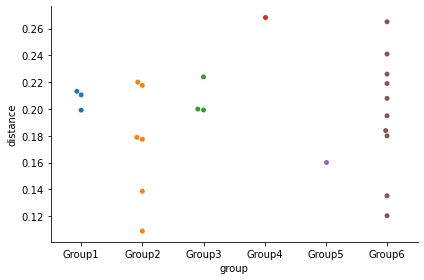

In [9]:
# Distances within groups

group_distances = {}

for group, df in thinned_dataset.groupby("Group"):
    group_distances[group] = []
    for c in itertools.combinations(df.Species.values, 2):
        sp1, sp2 = c
        if sp1==sp2:
            continue
        distance = b10k.get_distance(sp1, sp2)
        group_distances[group].append(distance)
        
group_distances_df = pd.DataFrame(sum([[k]*len(v) for k,v in group_distances.items()],[]),             
                                  sum([v for k,v in group_distances.items()],[])            
                                 ).reset_index()
group_distances_df.columns = ["distance", "group"]
sns.swarmplot(data = group_distances_df, x = "group", y = "distance")
sns.despine()
plt.tight_layout()
#plt.savefig("bird_intragroup_genetic_distance.pdf")

In [12]:
# Tree of all groups
b10k.prune(thinned_dataset.Species.values, preserve_branch_length=True)

sp2group = thinned_dataset[["Species","Group"]].set_index("Species").to_dict()["Group"]
sp2order = thinned_dataset[["Species","Order"]].set_index("Species").to_dict()["Order"]
sp2common = thinned_dataset[["Species","Common name"]].set_index("Species").to_dict()["Common name"]

nwk = toytree.tree(b10k.write(), tree_format=1)
colors_tips = [toyplot.color.brewer.palette("Set2")[int(sp2group[sp][-1])] for sp in nwk.get_tip_labels()]
tips = ["{},{}".format(sp2order[sp],sp2common[sp]) for sp in nwk.get_tip_labels()]

canvas, axes, mark = nwk.draw(
    tip_labels_align =True,
    tip_labels = tips,
    tip_labels_colors = colors_tips,
    height = 500,
    tip_labels_style={
        "font-size": "8px",
    }
);
#toyplot.pdf.render(canvas, "../scripts/pdfs/neoaves_groupings.pdf")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="455.0px" height="500.0px" viewBox="0 0 455.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t82eaddc669b542ce91d928c52bc92c7c"> Coraciiformes,Woodland Kingfisher Bucerotiformes,Northern Ground Hornbill Trogoniformes,Black-tailed Trogon Accipitriformes,Bald Eagle Falconiformes,Saker Falcon Passeriformes,Collared Flycatcher Sphenisciformes,Emperor Penguin Pelecaniformes,Little Egret Gruiformes,Grey-winged Trumpeter Charadriiformes,Ruff Cuculiformes,Common Cuckoo Otidiformes,Red-crested Bustard Columbiformes,Domestic Pigeon (Rock Dove) Pterocliformes,Burchell's Sandgrouse Galliformes,Chicken (Red Junglefowl) Galliformes,Helmeted Guineafowl Galliformes,White-crested Guan Anseriformes,Muscovy Duck Anseriformes,Magpie Goose

In [62]:
# Write all species to file
with open("./../data/Aves.txt", "w") as spf:
    spf.write(",".join(thinned_dataset.Species.values) + "\n")

In [10]:
# Write group-specific files
for group,df in thinned_dataset.groupby("Group"):
    
    species = list(df.Species)
    
    # Neoaves
    if "Gallus_gallus" not in species:
        species.append("Gallus_gallus")

    # Outside branch
    else:
        species.append("Taeniopygia_guttata")
    
    # Species list
    fix_group = group.replace("Group","g")
    with open("./../data/Aves_{}.txt".format(fix_group), "w") as spf:
        spf.write(",".join(species) + "\n")
    
    print(fix_group, species)
    # Tree
    b10k = Tree("./../trees/363-avian-2020-phast.nh", format=1)
    b10k.prune(species, preserve_branch_length=True)
    b10k.write(outfile="./../trees/Aves_{}.nwk".format(fix_group), format=5)

g1 ['Calidris_pugnax', 'Columba_livia', 'Pterocles_burchelli', 'Gallus_gallus']
g2 ['Aptenodytes_forsteri', 'Cuculus_canorus', 'Egretta_garzetta', 'Lophotis_ruficrista', 'Gallus_gallus']
g3 ['Bucorvus_abyssinicus', 'Halcyon_senegalensis', 'Trogon_melanurus', 'Gallus_gallus']
g4 ['Falco_cherrug', 'Ficedula_albicollis', 'Gallus_gallus']
g5 ['Haliaeetus_leucocephalus', 'Psophia_crepitans', 'Gallus_gallus']
g6 ['Anseranas_semipalmata', 'Cairina_moschata', 'Gallus_gallus', 'Numida_meleagris', 'Penelope_pileata', 'Taeniopygia_guttata']


In [30]:
thinned_dataset[["Species","Common name"]].to_csv("../data/latin2common_aves.txt",sep="\t", index=False)

In [15]:
b10k = Tree("./../trees/363-avian-2020-phast.nh", format=1)
b10k.prune(list(thinned_dataset.Species), preserve_branch_length=True)
nwk = toytree.tree(b10k.write(), tree_format=1)
colors_tips = ["black" if sp in list(thinned_dataset.Species) else "#F4F4F4" for sp in nwk.get_tip_labels()]
style = {"edge_style":{"stroke-width": 1}, "tip_labels_style":{"font-size": "10px", "-toyplot-anchor-shift": "3px"}}
canvas, axes, mark = nwk.draw(
    tip_labels_align=False,
    tip_labels_colors=colors_tips,
    tip_labels=[sp2common[sp] for sp in nwk.get_tip_labels()],
    height=500,
    **style
);
toyplot.pdf.render(canvas, "pdfs/birds.pdf")